In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from helper_functions import *

In [2]:
result_df = pd.read_csv('compare_mape.csv')
train = pd.read_csv('train.csv')
result_df.head()

,Country,MAPE,Density,Active,forecast,category,LR_MAPE,SV_MAPE
0,1001,1.504614,3.334431,1417,[3.3091352 3.31727028 3.32801533 3.33693123 3...,LR,0.992271,1.835232
1,1003,4.143341,7.823300,13401,[7.85833788 7.88518858 7.90744925 7.90828514 7...,tf_dense,4.317589,5.230218
2,1005,1.395184,1.206827,239,[1.16141069 1.16513038 1.17019248 1.18426347 1...,SV,1.833943,1.101416
3,1007,5.228748,1.236650,220,[1.22299695 1.22010887 1.22093809 1.21361172 1...,SV,4.259990,3.574082
4,1009,1.442244,1.777708,789,[1.75237012 1.76360607 1.77065146 1.7765491 1...,LR,1.285277,2.116541


In [3]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
forecast = []
mapes = []

IDE = train.cfips.unique()
x_train = np.arange(31).reshape((-1,1))
x_test = np.arange(31,39).reshape((-1,1))
# Iterate all the cfips
for i in range(len(IDE)):
    c = result_df['Country'].iloc[i]
    df = train.loc[train.cfips == c]
    last = df.microbusiness_density.values[-9]
    model = result_df[result_df['Country'] == c]['category'].values[0]
    if model == "tf_dense":
        # Train, predict with tensorflow dense layer
        HORIZON = 8
        WINDOW_SIZE = 8
        
        # Create train dataset
        windows, labels = make_windows(df.microbusiness_density.values, window_size=WINDOW_SIZE, horizon=HORIZON)
    
        # Split trin and test set
        train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows, labels)
    
        # create model
        tf.random.set_seed(42)

        model = tf.keras.Sequential([
                    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                    layers.Dense(128, activation="relu"),
                    layers.Dense(128, activation="relu"),
                    layers.Dense(128, activation="relu"),
                    layers.Dense(HORIZON)
                ], name='dense_model')
    
        model.compile(loss='mae', 
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['mae', 'mse'])

        model.fit(x=train_windows, 
                 y=train_labels, 
                 epochs=500,
                 batch_size=256, verbose=0)
    
        # Predict test data
        p = make_preds(model, test_windows)
        # Shift to adjust to last value - see if this result makes better
        shift = last - p[0]
        preds = p[:]+shift
        # Evaluate 
        results = evaluate_preds(test_labels, preds)
        mape = results['mape']
        # Append mape result
        mapes.append(mape)
        # Append prediction result
        forecast.append(preds)
        
    elif model == "LR":
        # Train with Linear regression
    
        model = LinearRegression()
        model.fit(x_train,df['microbusiness_density'][:31])
        p = model.predict(x_train)

        # Compute train error
        err = p - df['microbusiness_density'][:31].values
        rng = df['microbusiness_density'].max() - df['microbusiness_density'].min()

        # Determin if time series is linear or not
        s = 0
        for k in range(31):
            e = np.abs(err[k])
            r = e / rng # absolute error divided by range
            s += r
        s = s/31 # now S is MAPE mean absolute percentage error 
   

        # Infer test data with linear regression
        p2 = model.predict(x_test)
        shift = last - p2[0]
        # Get Renear Regression results    
        preds = p2[:]+shift
        test_label = np.expand_dims(np.array(train[train['cfips'] == c]['microbusiness_density'][31:39]), axis=0)
        results = evaluate_preds(test_label, preds)
        m = results['mape']
        forecast.append(np.array(preds).reshape((-1)))
        mapes.append(m)

    else:
        # Rest of the country use the last value as the preds
        preds = [last]*8
        test_label = np.expand_dims(np.array(train[train['cfips'] == c]['microbusiness_density'][31:39]), axis=0)
        results = evaluate_preds(test_label, preds)
        m = results['mape']
        forecast.append(np.array(preds).reshape((-1)))
        mapes.append(m)
    
result_df['new_mape'] = mapes


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 291ms/step


In [5]:
forecast_to_submit = np.array(forecast).reshape((-1))

In [6]:
result_df.to_csv('forecast_with_category.csv', index=False)

## Load saved dataset and farther analysis

In [25]:
result_df = pd.read_csv('forecast_with_category.csv')
result_df.head()

,Country,MAPE,Density,Active,forecast,category,LR_MAPE,SV_MAPE,mix_model_mape
0,1001,1.504614,3.334431,1417,[3.3091352 3.31727028 3.32801533 3.33693123 3...,LR,0.992271,1.835232,0.992271
1,1003,4.143341,7.823300,13401,[7.85833788 7.88518858 7.90744925 7.90828514 7...,tf_dense,4.317589,5.230218,4.567517
2,1005,1.395184,1.206827,239,[1.16141069 1.16513038 1.17019248 1.18426347 1...,SV,1.833943,1.101416,1.101416
3,1007,5.228748,1.236650,220,[1.22299695 1.22010887 1.22093809 1.21361172 1...,SV,4.259990,3.574082,3.574082
4,1009,1.442244,1.777708,789,[1.75237012 1.76360607 1.77065146 1.7765491 1...,LR,1.285277,2.116541,1.285277


In [26]:
mape_data = result_df[['Country', 'MAPE', 'LR_MAPE', 'SV_MAPE', 'mix_model_mape']]
mape_data.head()

,Country,MAPE,LR_MAPE,SV_MAPE,mix_model_mape
0,1001,1.504614,0.992271,1.835232,0.992271
1,1003,4.143341,4.317589,5.230218,4.567517
2,1005,1.395184,1.833943,1.101416,1.101416
3,1007,5.228748,4.259990,3.574082,3.574082
4,1009,1.442244,1.285277,2.116541,1.285277


In [27]:
# Compare those three numbers and categorize by the best score. 
best_scores = mape_data.min(axis='columns')
cat = []
for i, m in enumerate(best_scores):
    if m == result_df['MAPE'].iloc[i]:
        category = 'tf_dense'
        cat.append(category)
    elif m == result_df["LR_MAPE"].iloc[i]:
        category = "LR"
        cat.append(category)
    elif m == result_df['SV_MAPE'].iloc[i]:
        category = "SV"
        cat.append(category)
    else:
        category = 'correction'
        cat.append(category)
mape_data['category'] = cat
mape_data.head()

C:\Users\Masa\AppData\Local\Temp\ipykernel_10632\1042024412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mape_data['category'] = cat


,Country,MAPE,LR_MAPE,SV_MAPE,mix_model_mape,category
0,1001,1.504614,0.992271,1.835232,0.992271,LR
1,1003,4.143341,4.317589,5.230218,4.567517,tf_dense
2,1005,1.395184,1.833943,1.101416,1.101416,SV
3,1007,5.228748,4.259990,3.574082,3.574082,SV
4,1009,1.442244,1.285277,2.116541,1.285277,LR


In [28]:
mape_data['category'].value_counts()

SV            1486
LR             851
tf_dense       666
correction     132
Name: category, dtype: int64

In [29]:
mape_data[mape_data['category'] == 'correction']

,Country,MAPE,LR_MAPE,SV_MAPE,mix_model_mape,category
30,1061,1.490287,1.555328,2.640408,1.180391,correction
41,1083,0.807067,0.839026,0.961288,0.716099,correction
85,2188,18.246477,25.648949,18.631130,17.503181,correction
129,5041,4.138540,4.987184,4.371863,3.271110,correction
135,5053,5.284841,5.578218,6.678519,4.549094,correction
...,...,...,...,...,...,...
3069,55059,2.116703,3.057424,2.253825,1.931531,correction
3070,55061,1.503734,1.691444,2.088804,1.355851,correction
3074,55069,3.041982,3.351717,4.072621,2.720333,correction
3102,55123,0.175896,0.350205,0.324751,0.173850,correction


In [30]:
mape_data.describe()

,Country,MAPE,LR_MAPE,SV_MAPE,mix_model_mape
count,3135.000000,3135.000000,3.135000e+03,3135.000000,3135.000000
mean,30376.037640,27.996707,8.927551e+03,3.909992,3.602429
std,15145.862593,1269.835687,4.995858e+05,21.621562,24.491129
min,1001.000000,0.175896,2.424637e-01,0.000000,0.000000
25%,18178.000000,1.800255,1.664201e+00,1.394263,1.133801
50%,29173.000000,3.101383,2.748950e+00,2.353172,2.013470
75%,45076.000000,5.295601,4.815689e+00,3.993313,3.490142
max,56045.000000,71091.580000,2.797235e+07,1183.264800,1347.840800


## try get histgram on mix_model_mape

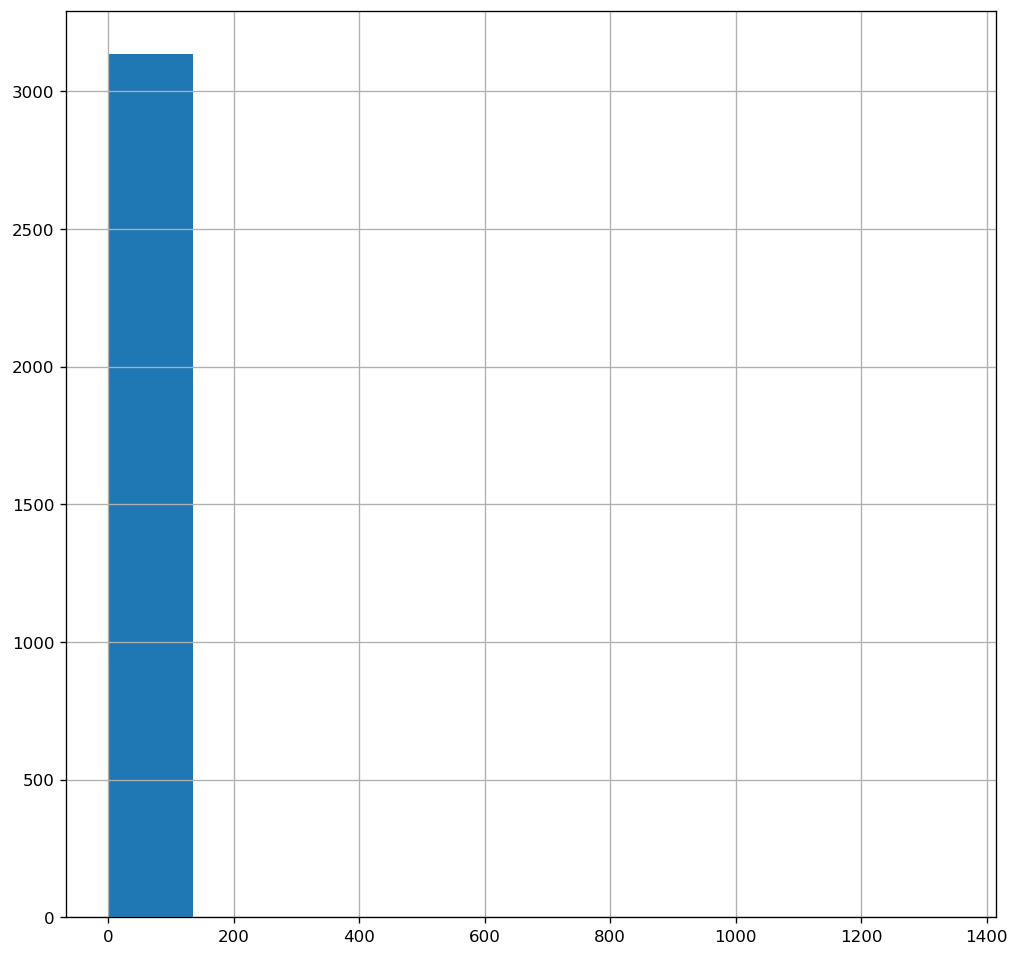

In [33]:
plt.figure(figsize=(10, 10), dpi=120)
mape_data['mix_model_mape'].hist();

## Conclusion:

Average MAPE increased significantly by using multiple model to get prediction. Now is the time to apply on Kaggle by using same model as this. 